# 參數優化 - 將歷史報酬提升數倍的方式！

這個單元中，我們首先要來撰寫一個獲利的策略

寫一個策略，首先要來將我們之前爬到的數據拿出來

## 拿出歷史大盤數據

In [2]:
from finlab.data import Data

data = Data()
twii = data.get('發行量加權股價指數')
twii = twii[(twii.index.second == 0)]['台股指數']
twii.tail(500)

date
2019-12-04 09:42:00    11493.39
2019-12-04 09:43:00    11497.04
2019-12-04 09:44:00    11494.47
2019-12-04 09:45:00    11498.34
2019-12-04 09:46:00    11498.05
2019-12-04 09:47:00    11494.65
2019-12-04 09:48:00    11498.78
2019-12-04 09:49:00    11496.26
2019-12-04 09:50:00    11494.64
2019-12-04 09:51:00    11494.67
2019-12-04 09:52:00    11493.22
2019-12-04 09:53:00    11497.75
2019-12-04 09:54:00    11495.17
2019-12-04 09:55:00    11486.59
2019-12-04 09:56:00    11487.84
2019-12-04 09:57:00    11487.54
2019-12-04 09:58:00    11491.61
2019-12-04 09:59:00    11487.64
2019-12-04 10:00:00    11491.97
2019-12-04 10:01:00    11491.64
2019-12-04 10:02:00    11488.06
2019-12-04 10:03:00    11491.93
2019-12-04 10:04:00    11487.19
2019-12-04 10:05:00    11493.25
2019-12-04 10:06:00    11492.04
2019-12-04 10:07:00    11486.43
2019-12-04 10:08:00    11487.43
2019-12-04 10:09:00    11488.81
2019-12-04 10:10:00    11485.35
2019-12-04 10:11:00    11485.74
                         ...   
201

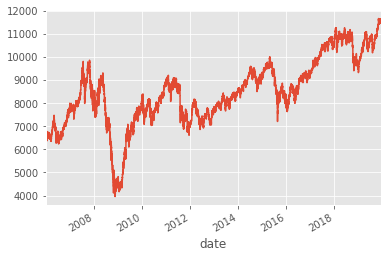

In [3]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

%matplotlib inline

twii.plot()

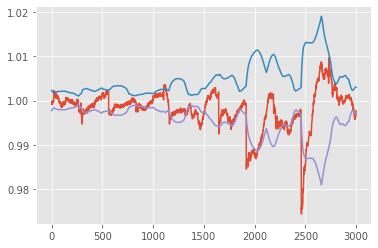

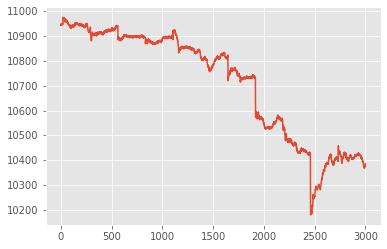

In [19]:
sma240 = twii.rolling(240).mean()          # 設定ma240年均線
bias = twii / sma240                       # 乖離率 (加權指數與年均線的乖離....) twii(股價) >年均線就是大於１
ub = 1 + bias.rolling(200).std() * 2      #  std() =>一段時間內的變動量
lb = 1 - bias.rolling(200).std() * 2

import matplotlib.pyplot as plt

plt.plot(bias.values[-3000:])
plt.plot(ub.values[-3000:])
plt.plot(lb.values[-3000:])
plt.show()                                 # 區分上面三張、下面一張圖的功用　　　　　
plt.plot(twii.values[-3000:])

## 乖離率策略

10400.330000000002

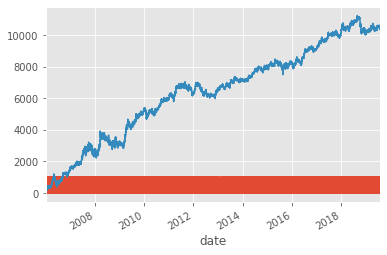

In [18]:
import numpy as np
import pandas as pd
%matplotlib inline

def strategy(m1=500, m2=1000, m3=1, m4=1, draw_plot=False):
    
    
    sma = twii.rolling(m1).mean()

    bias = (twii / sma)
    ub = 1 + bias.rolling(m2).std() * m3
    lb = 1 - bias.rolling(m2).std() * m4
    
    buy = (bias < lb)                            #當乖離率大於upperbound，股價會持續往上漲，應該要買入。 
    sell = (bias > ub)                           #當乖離率小於lowerboung，股價會持續下跌，應該要賣出。
    #課程中有介紹順勢還是逆勢操作，上述兩行要自己調整，否則策略不同結果差異很大。

    hold = pd.Series(np.nan, index=sell.index)   # 建立一個新的Series 命名為:hold
    hold[buy] = 0                                # 其中, buy的欄位=0, sell的欄位=1
    hold[sell] = 1
    hold = hold.ffill()                          # 將其他not a number的地方補上前面的數值...

    returns = twii.shift(-2) - twii.shift(-1)     # 時間差： shift(-2)=>前兩分鐘買入
    
    
    
    returns[hold == 0] = 0                        # returns[hold ==0]
    #returns -= hold.diff().abs() * 3              # 當buy轉為sell互換時就會有個差值，代表有買賣行為就算一次交易費用
                                                  # 滑價+交易手續費，大約點數的三倍，過度交易會侵蝕獲利。
                                                  # 若不考慮過度交易 ，line28可以註解調。

    creturn = returns.cumsum()                    # cumulate sum 累積報酬率：將獲利累積加起來。
    
    
    
    if draw_plot:
        (hold*1000).plot()
        creturn.plot()
    
     
    return creturn.dropna()[-1]                    # .dropna()  => 如果有not a number就捨棄

    
strategy(300, 20, 1 , 1, draw_plot=True)

## 乖離率優化

In [25]:
vmax = 0
for m1 in range(500, 2000, 100):
    for m2 in range(800, 3000, 100):
        v = strategy(m1, m2, 1, 1)
        if v > vmax:                     #如果回測的結果有更高才會列出來!
            vmax = v
            print(vmax, m1, m2, 1, 1)

7645.890000000006 500 800 1 1
7736.659999999991 600 1300 1 1
7754.819999999989 600 1400 1 1
8060.139999999992 600 1500 1 1
8372.979999999998 600 1800 1 1
8473.03 600 2000 1 1
8608.44999999999 700 1200 1 1
9457.429999999993 700 1300 1 1
10012.989999999993 700 1400 1 1
10067.769999999991 700 1600 1 1
10557.869999999992 1300 800 1 1
10689.059999999998 1400 800 1 1


## 繪製出歷史報酬

10893.900000000003

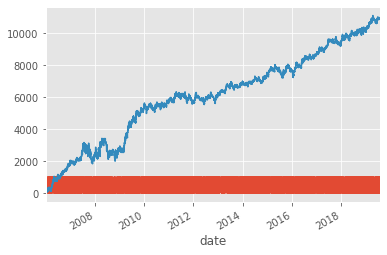

In [23]:
strategy(700, 460, 1, 1, draw_plot=True)